# Final Exam - Number 1 - Haarcascade + HSV

Course: Computer Vision

Name: Rio Pramana

NIM: 2440016804

Class: LA01

# Import libraries & initialize variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os import listdir

In [2]:
CASCADE_PATH = "./haarcascade_frontalface_default.xml"
IMAGES_PATH = "./images"
mask_label = {
        0:'NOT RED',
        1:'RED'
    }

# Defining functions for detecting red faces in images

In this code, I will be working with grayscale image to simplify the process of face detection. So, when I read the input image, I also return the grayscaled image

In [3]:
def read_and_preprocess_img(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #turn the image to grayscale and save it to another variable
    return img, img_gray

The function below will read all image in the `images` folder, and returns a list of each image and grayscale image. It will first get all file names from the given path (path to the images folder), then it will loop the file names (`data_list`) to read the image and turn it to grayscale

In [4]:
def get_dataset(path):
    data_list = listdir(path) # get all file names in the path
    images = []
    images_gray = []
    
    for image_name in data_list: # Loop through every file name
        img, img_gray = read_and_preprocess_img(f"{path}/{image_name}")
        images.append(img)
        images_gray.append(img_gray)
    
    return images, images_gray

The function below returns the face classifier cascade. In this case, I used haarcascade_frontalface_default.xml because most of the images given contains frontal faces

In [5]:
def load_face_detector(cascade_path):
    haarcascade_path = cascade_path
    face_clf_cascade = cv2.CascadeClassifier(haarcascade_path)
    
    return face_clf_cascade

The function below will detect faces and return the results. It accepts arguments to change the parameters such as scaleFactor and minNeighbors, but I have set a default value (I have tried and tested many values, I found that these default values was able to detect faces more accurately) for each one

In [6]:
def detect_faces(face_clf_cascade, img, scaleFactor = 1.1, minNeighbors = 5, minSize = (30,30)):
    detected_faces = face_clf_cascade.detectMultiScale(
        image = img,
        scaleFactor = scaleFactor,
        minNeighbors = minNeighbors,
        minSize = minSize
    )
    
    return detected_faces

The function below is used to crop the original image into just the face of the detected person/face. `face_img` will be the ROI that is going to be processed to determine whether or not it is red. The bounding box is used to crop the image where x & y are the starting coordinate of the face detected, and w & h are the width and height of the bounding box

In [7]:
def crop_face(img, face_rect):
    (x,y,w,h) = face_rect # get x & y coordinate of the face, and w & h of the bounding box
    face_img = img[y:y+h,x:x+w] #crop the image
    return face_img

The function below tries to extract contours from the `mask` which will be a binary image. I am using `findContours()` from opencv to find the contours that will only obtain the outer boundaries of the object (using `cv2.RETR_EXTERNAL`). `cv2.CHAIN_APPROX_SIMPLE` is used to only keep the end points.

The second line (`cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]`) is necessary because the function `cv2.findContours()` can return 2 different outputs. The first possible output is a tuple with the length of 3 which contains the list of contours in index 1, and the other possible output is a tuple with the length of 2 which contains the list of contours in index 0

The contours will then be sorted by their contour area so that contours with the biggest area will be at the beginning of the list. Then, I filtered the contours by checking their area. If the contour area is less than half of the image, then it will not be considered as a good enough indicator of a red face (it could be a contour of a red object that is really close to the face, such as earrings or lipstick). I tried many values for the area threshold and I found that 50% gives out a more accurate results.

The function then returns the contours that are assumed (with good confidence) to be the contour of a red face

In [8]:
def get_face_contours(mask, face_shape):
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find contours in the mask
    # only retain the list of contours
    if len(contours) == 2:
        contours = contours[0]
    else:
        contours = contours[1]
    # sort the contours based on its area
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    face_contours = []
    # Filter the contours
    if sorted_contours != []:
        # Set the threshold for the face contour
        area_percentage = (50.0 / 100.0) # 50% of the image
        area_threshold = (face_shape[0] * face_shape[1] * area_percentage)
        contours_length = len(sorted_contours)
        # Check each contour with the threshold
        for k in range(contours_length):
            if cv2.contourArea(sorted_contours[k]) < area_threshold:
                face_contours = sorted_contours[0:k]
                break
            # Else if there is only 1 contour and it is bigger than the threshold, then add it..
            #..because it means that it is a contour of a red face
            # The if statement above only works when there is a contour that is less than then threshold
            # There should only be 1 contour of the red face if the red color detection works correctly
            elif contours_length == 1:
                face_contours = sorted_contours[0]
    return face_contours

The function below will check if the ROI (cropped image that only shows the face area) is red (the logic to see if the amount of red is big enough and making sure it is a face is done in the previous function).

This is done by looking at the HSV values of the image. I am using 2 masks to get a better filter for the red colors, and after some experimenting, I found that the lower and upper bounds values for the masks that I'm using yields more accurate results.

I set the Saturation value and the Value in the lower bounds to 120 & 70 respectively to make sure the masks do not detect really light red or white colors (both have low Saturation) as it made the results inaccurate.

After getting the contours (which should only contain contours that represents a red face), I then check if it is empty or not. If it is empty, that means there is no red face detected and it should return False. Otherwise, it returns True

In [9]:
def check_red_colour_person(roi):
#     show_img(roi)
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV) # turn to hsv
    # Mask/threshold the image using the lower and upper bounds
    mask1 = cv2.inRange(hsv, np.array([0, 120, 70]), np.array([10, 255, 255]))
    mask2 = cv2.inRange(hsv, np.array([165, 120, 70]), np.array([180, 255, 255]))
    mask = mask1 | mask2
    # Get and filter the face contours
    face_contours = get_face_contours(mask, roi.shape[:2])
#     plt.imshow(mask, cmap = "gray")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    
    # Determine whether a red face is detected or not
    if len(face_contours) != 0:
        return True
    else:
        return False

The function below is used to display image using matplotlib

In [10]:
def show_img(img):
    plt.figure(figsize=(10, 8))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

The function below is used to determine the bounding box's color based on its label. If it is a red face, then the box outline will be `green`, else it will be `light blue`

In [11]:
def return_color(img_label):
    if (img_label == "RED"):
        return (0, 255, 0)
    else:
        return (240, 255, 0)

The function below is used to draw the bounding box of the face and display its prediction (red face or not)

In [12]:
def label_face(img, img_label, face):
    (x,y,w,h) = face
    color = return_color(img_label)
    cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
    cv2.putText(img, img_label, (x, y-3), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
    
    return img

The function below is the function used to check each face whether it is red or not. It will loop through every face that are detected, then check if it is red or not. If it is red, `red_face_count` is incremented by 1, and then it will label the face in the image based on the result

In [13]:
def detect_red_face(img, faces):
    red_face_count = 0
    for face in faces:
        # Check if it is a red face or not
        is_red = check_red_colour_person(crop_face(img, face))
        if (is_red):
            print("Red face detected!")
            red_face_count += 1
        # Label the face in the image based on the detection
        img_label = mask_label[is_red]
        img = label_face(img, img_label, face)
    print("Out of {} face(s) detected in the image, a total of {} red face(s) were detected".format(len(faces), red_face_count))
    
    return img

The function below is the main program that will apply all the functions above for each image in the `images` folder

In [14]:
def main_program():
    images, images_gray = get_dataset(IMAGES_PATH) # Get all data
    face_clf_cascade = load_face_detector(CASCADE_PATH)
    for index, img in enumerate(images): # Loop through each image
        img_gray = images_gray[index]
        faces = detect_faces(face_clf_cascade, img_gray)
        labeled_img = detect_red_face(img, faces)
        # Show the final result
        show_img(labeled_img)

# Running the code on the images

Red face detected!
Out of 9 face(s) detected in the image, a total of 1 red face(s) were detected


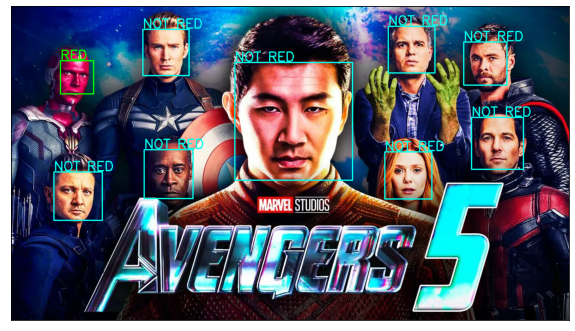

Out of 4 face(s) detected in the image, a total of 0 red face(s) were detected


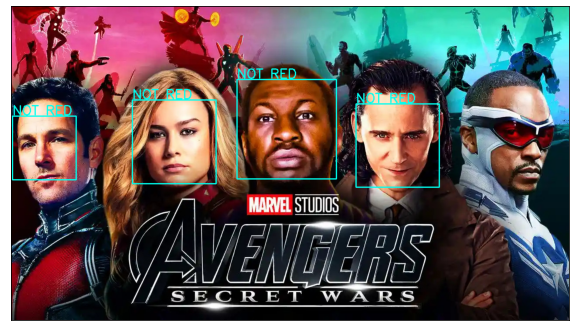

Red face detected!
Out of 1 face(s) detected in the image, a total of 1 red face(s) were detected


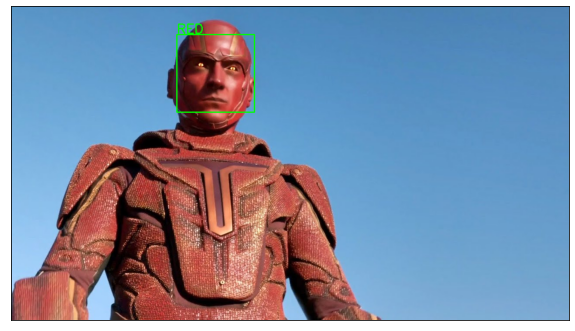

Red face detected!
Out of 1 face(s) detected in the image, a total of 1 red face(s) were detected


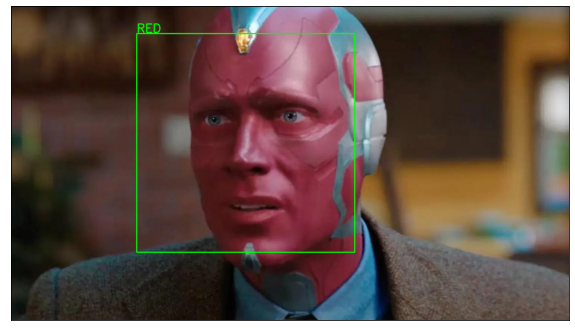

In [15]:
main_program()